# Which geodesic algorithm is best?

There are number of algorithms out there to calculate geodesic distances between two points on the surface of a mesh. In this noteboook, we compare the results of all of them on a simple example. We will compare the following libraries:

- [pygeodesic](https://pypi.org/project/pygeodesic/)
- [vedo](https://vedo.embl.es/)
- [gdist](https://pypi.org/project/gdist/)
- [potpourri3d](https://github.com/nmwsharp/potpourri3d)

In [3]:
import time

import gdist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import potpourri3d as pp3d
import pygeodesic.geodesic as geodesic
import seaborn as sns
import tqdm
import vedo

In [8]:
mesh = vedo.IcoSphere().subdivide()
mesh.vertices.shape

(10242, 3)

We now calculate the geodesic distance between two points on a sphere using all of these libraries and compare the results. Additionally, we will calculate the ground truth geodesic distance using the great arc distance formula:

$$
d = R \arccos(p_1 \cdot p_2)
$$

where $p_1$ and $p_2$ are the two points on the sphere and $R$ is the radius of the sphere. Additionally, we will also time the execution of each algorithm to see which one is the fastest.

In [54]:
df = pd.DataFrame(columns=[
    'n_vertices', 'distance', 'distance_great_arc', 'time', 'method'])

n_runs = 15

geoalg = geodesic.PyGeodesicAlgorithmExact(mesh.vertices, np.asarray(mesh.cells, dtype=int))
path_solver = pp3d.EdgeFlipGeodesicSolver(mesh.vertices, np.asarray(mesh.cells, dtype=int))
heat_solver = pp3d.MeshHeatMethodDistanceSolver(mesh.vertices, np.asarray(mesh.cells, dtype=int))

for i in tqdm.tqdm(range(n_runs)):
    vertex1 = np.random.randint(0, mesh.npoints)
    vertex2 = np.random.randint(0, mesh.npoints)

    # great arc distance between the two vertices
    great_arc_distance = np.arccos(np.dot(mesh.vertices[vertex1], mesh.vertices[vertex2]))

    # Geodesic distance using pygeodesic
    t0 = time.time()
    distance_pygeodesic = geoalg.geodesicDistance(vertex1, vertex2)[0]
    t1 = time.time()

    df = pd.concat([df, pd.DataFrame({
        'n_vertices': mesh.npoints,
        'distance': distance_pygeodesic,
        'distance_great_arc': great_arc_distance,
        'time': t1 - t0,
        'method': 'pygeodesic'
    }, index=[0])])

    # Geodesic distance using gdist
    t0 = time.time()
    distance_gdist = gdist.compute_gdist(mesh.vertices.astype(np.float64), np.asarray(mesh.cells, dtype=int),
                                            source_indices=np.array([vertex1]), target_indices=np.array([vertex2]))[0]
    t1 = time.time()

    df = pd.concat([df, pd.DataFrame({
        'n_vertices': mesh.npoints,
        'distance': distance_gdist,
        'distance_great_arc': great_arc_distance,
        'time': t1 - t0,
        'method': 'gdist'
    }, index=[0])])

    # Geodesic distance using vedo
    t0 = time.time()
    distance_vedo = mesh.geodesic(vertex1, vertex2)
    distance_vedo = sum(np.linalg.norm(distance_vedo.vertices[1:] - distance_vedo.vertices[:-1], axis=1))
    t1 = time.time()

    df = pd.concat([df, pd.DataFrame({
        'n_vertices': mesh.npoints,
        'distance': distance_vedo,
        'distance_great_arc': great_arc_distance,
        'time': t1 - t0,
        'method': 'vedo'
    }, index=[0])])

    # Geodesic distance using potpourri3d (edge flip)
    t0 = time.time()
    distance_pp3d = path_solver.find_geodesic_path(vertex1, vertex2)
    distance_pp3d = sum(np.linalg.norm(distance_pp3d[1:] - distance_pp3d[:-1], axis=1))
    t1 = time.time()

    df = pd.concat([df, pd.DataFrame({
        'n_vertices': mesh.npoints,
        'distance': distance_pp3d,
        'distance_great_arc': great_arc_distance,
        'time': t1 - t0,
        'method': 'potpourri3d'
    }, index=[0])])


    # Geodesic distance using potpourri (mesh heat)
    t0 = time.time()
    distance_pp3d = heat_solver.compute_distance(vertex1)[vertex2]
    t1 = time.time()

    df = pd.concat([df, pd.DataFrame({
        'n_vertices': mesh.npoints,
        'distance': distance_pp3d,
        'distance_great_arc': great_arc_distance,
        'time': t1 - t0,
        'method': 'potpourri3d_heat'
    }, index=[0])])

  0%|          | 0/15 [00:00<?, ?it/s]C:\Users\Johan\AppData\Local\Temp\ipykernel_821988\1104836578.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({
100%|██████████| 15/15 [00:01<00:00, 14.63it/s]


## Analysis

Let's compare the results of the algorithms first. We see that vedo sticks out, which is likely due to the used algorithm (Djikstra). The other algorithms are quite close to the ground truth:

In [55]:
# compare all distances to the great arc distance
df['difference_to_great_arc_absolute'] = np.abs(df['distance'].values - df['distance_great_arc'].values)
df['difference_to_great_arc_relative'] = df['difference_to_great_arc_absolute'].values / df['distance_great_arc'].values

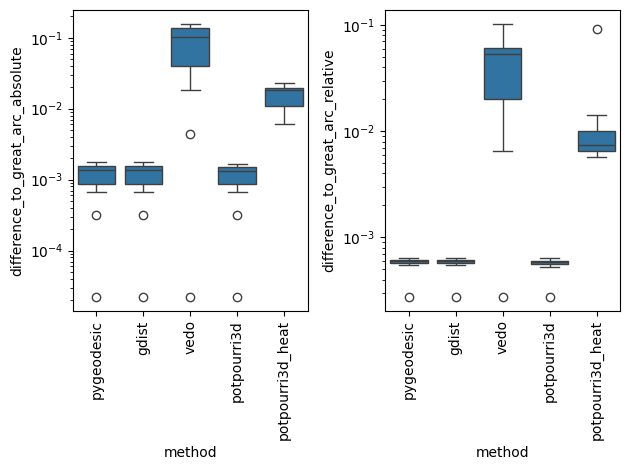

In [56]:
fig, axes = plt.subplots(ncols=2)

for ax in axes:
    ax.set_yscale('log')

handle = sns.boxplot(data=df, x='method', y='difference_to_great_arc_absolute', ax=axes[0])
handle2 = sns.boxplot(data=df, x='method', y='difference_to_great_arc_relative', ax=axes[1])

for tick in list(handle.get_xticklabels()) + list(handle2.get_xticklabels()):
    tick.set_rotation(90)

fig.tight_layout()

In terms of speed, we have two clear winners - vedo and potpourri3d. The other two libraries are significantly slower.

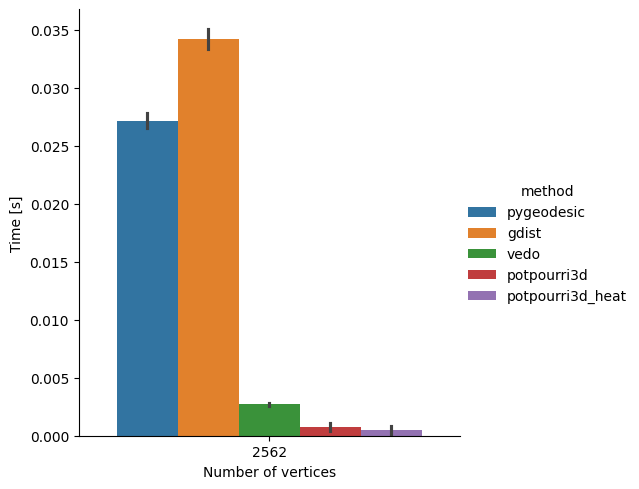

In [63]:
# compare all speeds with respect to the number of vertices
g = sns.catplot(data=df, x='n_vertices', y='time', hue='method', kind='bar')

# set x-labels
g.set_axis_labels('Number of vertices', 'Time [s]')

With that it's decided - we will go for gdist to calculate gedesic distances.